In [1]:
import pydot as pydot
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

from pathlib import Path
import pandas as pd
from zipfile import ZipFile
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from models import run_model_dep_classification, append_df_metrics, append_df_importances, create_df_importances
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from models import classification_metrics
import copy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import pydot
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from models import plot_roc_curve, plot_cm

PNS_DATA = Path('../data/processed/PNS_2019/all.zip').resolve()
zip_pns = ZipFile(PNS_DATA)
df = pd.read_csv(zip_pns.open(zip_pns.namelist()[0]), sep=",", low_memory=False)

PATH_GEN_DATA = Path('generated_data/pns_data_models').resolve()

# Criação das variaveis de interesse

#### Label

In [2]:
# Target
df['depression'] = np.where(df['phq9_total'].isna(), np.nan, np.where(df['phq9_total'] >= 10, 1, 0))
df = df.dropna(subset=['depression'])
df['depression'].value_counts()

depression
0.0    58451
1.0     6949
Name: count, dtype: int64

#### Features derivadas

In [3]:
# Alimentos in natura ou minimamente processado
innatura = ['P00601','P00602', 'P00603', 'P00604', 'P00605', 'P00607', 'P00608', 'P00609', 'P00610', 'P00611', 'P00612', 'P00613']
df_innatura = df[innatura]
df_innatura['qst_innatura'] = (df_innatura == 1.0).sum(axis=1)
# Alimentos ultraprocessados
ultraprocessados = ['P00614', 'P00615', 'P00616', 'P00617', 'P00618', 'P00619', 'P00620', 'P00621', 'P00622', 'P00623']
df_upf = df[ultraprocessados]
df_upf['qst_upf'] = (df_upf == 1.0).sum(axis=1)

# A literatura não usa a porcentagem de ultraprocessados do prato como análise. O artigo 'Food consumption and depression among Brazilian adults: results from the Brazilian National Health Survey, 2013'
# Usa como base o número de perguntas respondidas 'Sim' nos alimentos ultraprocessados das ultimas 24hrs
df['per_innatura'] = df_innatura['qst_innatura'] / (df_innatura['qst_innatura'] + df_upf['qst_upf']) * 100
df['per_upf'] = df_upf['qst_upf'] / (df_innatura['qst_innatura'] + df_upf['qst_upf']) * 100
df['qst_upf'] = df_upf['qst_upf'] # Baseado no artigo

def classify_upf(row):
    value = row['qst_upf']

    if  0 <= value < 2:
        return 1
    elif value < 4:
        return 2
    elif value < 6:
        return 3
    elif value < 8:
        return 4
    elif value <= 10:
        return 5

    return np.nan # questionario não respondido

df['upf_severity'] = df.apply(classify_upf, axis=1)


def count_imc(row):
    height = row['altura']
    weight = row['peso']

    imc = weight/np.square(height/100)   # Peso está em kg e altura em cm, no calculo do imc é kg/m^2
    return imc

df['imc'] = df.apply(count_imc, axis=1)


def classify_imc(row):
    value = row['imc']

    if  0 <= value < 18.5:
        return 1  # Baixo peso
    elif value < 24.9:
        return 2 # Eutrofia/peso adequado
    elif value < 29.9:
        return 3   # Sobrepeso
    elif value >= 30:
        return 4  # Obesidade

    return np.nan # questionario não respondido

df['class_imc'] = df.apply(classify_imc, axis=1)


def classify_idade(row):
    value = row['idade']
    if  18 <= value <= 29:
        return 1
    elif value <= 39:
        return 2
    elif value <= 49:
        return 3
    elif value <= 59:
        return 4

    return np.nan

df['class_idade'] = df.apply(classify_idade, axis=1)


# Essa variável foi criada a partir de um índice utilizado pela OMS. Na literatura, usam a pergunta 'P034' relacionada à prática de exercícios físicos nos ultimos 3 meses
df_activity = pd.DataFrame()
df_activity['minutes_per_week'] = df['P03702'] * df['P035']

vigorous_activities = [3.0, 4.0, 5.0, 6.0, 12.0, 13.0, 15.0]
moderated_activities = [1.0, 2.0, 7.0, 8.0, 9.0, 10.0, 11.0, 14.0, 16.0, 17.0]
df_activity['time_vigorous'] = df_activity['minutes_per_week'].loc[df['P036'].isin(vigorous_activities)]
df_activity['time_moderated'] = df_activity['minutes_per_week'].loc[df['P036'].isin(moderated_activities)]

df_activity['activity_class'] = 0
df_activity.loc[df_activity['minutes_per_week'].isna(), 'activity_class'] = np.nan
df_activity.loc[(df_activity['time_vigorous'] >= 75) | (df_activity['time_moderated'] >= 150), 'activity_class'] = 1

df['activity_class'] = df_activity['activity_class']
df['exerc_fisico'] = np.where(df['P034'].isin([1.0]), 1, np.where(df['P034'] == 2.0, 0, np.nan))
df['tabagismo'] = np.where(df['P050'].isin([1.0, 2.0]), 1, np.where(df['P050'] == 3.0, 0, np.nan))

# Na literatura eles usam outra variável para analisar o consumo alcoolico
df['cons_alcool'] = np.where(df['P02801'] >= 1, 1, 0)
df['cons_alcool'] = np.where(df['P02801'].isna(), np.nan, df['cons_alcool'])

# Olhar artigo 'Food consumption and depression among Brazilian adults: results from the Brazilian National Health Survey, 2013'
df['cons_alcool'] = np.where(df['P027'].isin([2.0, 3.0]), 1, np.where(df['P027'] == 1.0, 0, np.nan))

df = df[df['P005'] != 1.0] #Retirando as grávidas da análise

df['obesidade'] = np.where(df['class_imc'].isna(), np.nan, np.where(df['class_imc'] >= 4, 1, 0))

# Limitação da análise por idades que se adequam ao PHQ9 baseado no artigo 'Food consumption and depression among Brazilian adults: results from the Brazilian National Health Survey, 2013'
df = df[(df['idade'] >= 18) & (df['idade'] <= 59)]


regiao_mapping = {
    'r_norte': [11, 12, 13, 14, 15, 16, 17],
    'r_nordeste': [21, 22, 23, 24, 25, 26, 27, 28, 29],
    'r_sudeste': [31, 32, 33, 35],
    'r_sul': [41, 42, 43],
    'r_centro_oeste': [50, 51, 52, 53]
}

for regiao, estados in regiao_mapping.items():
    df[regiao] = df['uf'].apply(lambda x: int(x in estados))


df['class_renda'] = np.where(df['renda_pc'].isin([4.0, 5.0, 6.0, 7.0]), 1, np.where(df['renda_pc'].isin([1.0, 2.0, 3.0]), 0, np.nan))

/tmp/ipykernel_29181/2773495642.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_innatura['qst_innatura'] = (df_innatura == 1.0).sum(axis=1)
/tmp/ipykernel_29181/2773495642.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_upf['qst_upf'] = (df_upf == 1.0).sum(axis=1)


In [4]:
df['depression'].value_counts()

depression
0.0    57816
1.0     6848
Name: count, dtype: int64

# Análise de dados faltantes

#### População total

In [5]:
print('Faltantes em Q092 - pergunta do diagnóstico de depressão: ', df['Q092'].isna().sum(), 'Perc:',  round(df['Q092'].isna().sum()/len(df['Q092'])*100, 3))
print('Faltantes em PHQ9_total - classificação de grau de depressão: ', df['phq9_total'].isna().sum(), 'Perc:',  round(df['phq9_total'].isna().sum()/len(df['phq9_total'])*100, 3))
print('Faltantes em vive_conjugue - classificação do estado civil: ', df['vive_conjugue'].isna().sum(), 'Perc:',  round(df['vive_conjugue'].isna().sum()/len(df['vive_conjugue'])*100, 3))
print('Faltantes em class_idade - classificação de idade: ', df['class_idade'].isna().sum(), 'Perc:',  round(df['class_idade'].isna().sum()/len(df['class_idade'])*100, 3))
print('Faltantes em cor - cor ou raça autodeclaradas: ', df['cor'].isna().sum(), 'Perc:',  round(df['cor'].isna().sum()/len(df['cor'])*100, 3))

print('Faltantes em UPF_severity - classificação de consumo de ultraprocessados: ', df['upf_severity'].isna().sum(), 'Perc:',  round(df['upf_severity'].isna().sum()/len(df['upf_severity'])*100, 3))
print('Faltantes em exerc_fisico - classificação de atividade física: ', df['exerc_fisico'].isna().sum(), 'Perc:',  round(df['exerc_fisico'].isna().sum()/len(df['exerc_fisico'])*100, 3))
print('Faltantes em tabagist - classificação de tabagismo: ', df['tabagismo'].isna().sum(), 'Perc:',  round(df['tabagismo'].isna().sum()/len(df['tabagismo'])*100, 3))
print('Faltantes em cons_alcool - classificação do consumo de álcool: ', df['cons_alcool'].isna().sum(), 'Perc:',  round(df['cons_alcool'].isna().sum()/len(df['cons_alcool'])*100, 3))

print('Faltantes em Q120 - pergunta do diagnóstico de cancer: ', df['Q120'].isna().sum(), 'Perc:',  round(df['Q120'].isna().sum()/len(df['Q120'])*100, 3))
print('Faltantes em Q00201 - diagnotisco pressão alta: ', df['Q00201'].isna().sum(), 'Perc:',  round(df['Q00201'].isna().sum()/len(df['Q00201'])*100, 3))
print('Faltantes em Q03001 - diagnostico diabetes: ', df['Q03001'].isna().sum(), 'Perc:',  round(df['Q03001'].isna().sum()/len(df['Q03001'])*100, 3))
print('Faltantes em Q06306 - diagnostico cardiovascular : ', df['Q06306'].isna().sum(), 'Perc:',  round(df['Q06306'].isna().sum()/len(df['Q06306'])*100, 3))
print('Faltantes em Q060 - diagnostico colesterol alto: ', df['Q060'].isna().sum(), 'Perc:',  round(df['Q060'].isna().sum()/len(df['Q060'])*100, 3))
print('Faltantes em Q068 - diagnostico de AVC: ', df['Q068'].isna().sum(), 'Perc:',  round(df['Q068'].isna().sum()/len(df['Q068'])*100, 3))
print('Faltantes em Q079 - diagnostico de artrite: ', df['Q079'].isna().sum(), 'Perc:',  round(df['Q079'].isna().sum()/len(df['Q079'])*100, 3))
print('Faltantes em class_imc - classificação de imc: ', df['class_imc'].isna().sum(), 'Perc:',  round(df['class_imc'].isna().sum()/len(df['class_imc'])*100, 3))

Faltantes em Q092 - pergunta do diagnóstico de depressão:  0 Perc: 0.0
Faltantes em PHQ9_total - classificação de grau de depressão:  0 Perc: 0.0
Faltantes em vive_conjugue - classificação do estado civil:  0 Perc: 0.0
Faltantes em class_idade - classificação de idade:  0 Perc: 0.0
Faltantes em cor - cor ou raça autodeclaradas:  0 Perc: 0.0
Faltantes em UPF_severity - classificação de consumo de ultraprocessados:  0 Perc: 0.0
Faltantes em exerc_fisico - classificação de atividade física:  0 Perc: 0.0
Faltantes em tabagist - classificação de tabagismo:  0 Perc: 0.0
Faltantes em cons_alcool - classificação do consumo de álcool:  0 Perc: 0.0
Faltantes em Q120 - pergunta do diagnóstico de cancer:  0 Perc: 0.0
Faltantes em Q00201 - diagnotisco pressão alta:  1495 Perc: 2.312
Faltantes em Q03001 - diagnostico diabetes:  5410 Perc: 8.366
Faltantes em Q06306 - diagnostico cardiovascular :  0 Perc: 0.0
Faltantes em Q060 - diagnostico colesterol alto:  6369 Perc: 9.849
Faltantes em Q068 - diagno

## População considerada depressiva (PHQ9>=10)

In [6]:
new_df = df[df['phq9_total'] >= 10].copy()
print('Faltantes em Q092 - pergunta do diagnóstico de depressão: ', new_df['Q092'].isna().sum(), 'Perc:',  round(new_df['Q092'].isna().sum()/len(new_df['Q092'])*100, 3))
print('Faltantes em vive_conjugue - classificação do estado civil: ', new_df['vive_conjugue'].isna().sum(), 'Perc:',  round(new_df['vive_conjugue'].isna().sum()/len(new_df['vive_conjugue'])*100, 3))
print('Faltantes em class_idade - classificação de idade: ', new_df['class_idade'].isna().sum(), 'Perc:',  round(new_df['class_idade'].isna().sum()/len(new_df['class_idade'])*100, 3))
print('Faltantes em cor - cor ou raça autodeclaradas: ', new_df['cor'].isna().sum(), 'Perc:',  round(new_df['cor'].isna().sum()/len(new_df['cor'])*100, 3))

print('Faltantes em UPF_severity - classificação de consumo de ultraprocessados: ', new_df['upf_severity'].isna().sum(), 'Perc:',  round(new_df['upf_severity'].isna().sum()/len(new_df['upf_severity'])*100, 3))
print('Faltantes em activity_class - classificação de atividade física: ', new_df['activity_class'].isna().sum(), 'Perc:',  round(new_df['activity_class'].isna().sum()/len(new_df['activity_class'])*100, 3))
print('Faltantes em tabagist - classificação de tabagismo: ', new_df['tabagismo'].isna().sum(), 'Perc:',  round(new_df['tabagismo'].isna().sum()/len(new_df['tabagismo'])*100, 3))
print('Faltantes em cons_alcool - clasificação do consumo de álcool: ', new_df['cons_alcool'].isna().sum(), 'Perc:',  round(new_df['cons_alcool'].isna().sum()/len(new_df['cons_alcool'])*100, 3))

print('Faltantes em Q120 - pergunta do diagnóstico de cancer: ', new_df['Q120'].isna().sum(), 'Perc:',  round(new_df['Q120'].isna().sum()/len(new_df['Q120'])*100, 3))
print('Faltantes em Q00201 - diagnotisco pressão alta: ', new_df['Q00201'].isna().sum(), 'Perc:',  round(new_df['Q00201'].isna().sum()/len(new_df['Q00201'])*100, 3))
print('Faltantes em Q03001 - diagnostico diabetes: ', new_df['Q03001'].isna().sum(), 'Perc:',  round(new_df['Q03001'].isna().sum()/len(new_df['Q03001'])*100, 3))
print('Faltantes em Q06306 - diagnostico cardiovascular : ', new_df['Q06306'].isna().sum(), 'Perc:',  round(new_df['Q06306'].isna().sum()/len(new_df['Q06306'])*100, 3))
print('Faltantes em Q060 - diagnostico colesterol alto: ', new_df['Q060'].isna().sum(), 'Perc:',  round(new_df['Q060'].isna().sum()/len(new_df['Q060'])*100, 3))
print('Faltantes em Q068 - diagnostico de AVC: ', new_df['Q068'].isna().sum(), 'Perc:',  round(new_df['Q068'].isna().sum()/len(new_df['Q068'])*100, 3))
print('Faltantes em Q079 - diagnostico de artrite: ', new_df['Q079'].isna().sum(), 'Perc:',  round(new_df['Q079'].isna().sum()/len(new_df['Q079'])*100, 3))
print('Faltantes em class_imc - classificação de imc: ', new_df['class_imc'].isna().sum(), 'Perc:',  round(new_df['class_imc'].isna().sum()/len(new_df['class_imc'])*100, 3))

Faltantes em Q092 - pergunta do diagnóstico de depressão:  0 Perc: 0.0
Faltantes em vive_conjugue - classificação do estado civil:  0 Perc: 0.0
Faltantes em class_idade - classificação de idade:  0 Perc: 0.0
Faltantes em cor - cor ou raça autodeclaradas:  0 Perc: 0.0
Faltantes em UPF_severity - classificação de consumo de ultraprocessados:  0 Perc: 0.0
Faltantes em activity_class - classificação de atividade física:  4570 Perc: 66.735
Faltantes em tabagist - classificação de tabagismo:  0 Perc: 0.0
Faltantes em cons_alcool - clasificação do consumo de álcool:  0 Perc: 0.0
Faltantes em Q120 - pergunta do diagnóstico de cancer:  0 Perc: 0.0
Faltantes em Q00201 - diagnotisco pressão alta:  71 Perc: 1.037
Faltantes em Q03001 - diagnostico diabetes:  353 Perc: 5.155
Faltantes em Q06306 - diagnostico cardiovascular :  0 Perc: 0.0
Faltantes em Q060 - diagnostico colesterol alto:  443 Perc: 6.469
Faltantes em Q068 - diagnostico de AVC:  0 Perc: 0.0
Faltantes em Q079 - diagnostico de artrite:  

# Modelos

In [7]:
df_metrics_all = pd.DataFrame()
df_importances_all = pd.DataFrame()

### Seleção das variaveis e ajustes

In [8]:
df_total = pd.DataFrame()

df_total['exerc_fisico'] = df['exerc_fisico']
df_total['tabagismo'] = df['tabagismo']
df_total['cons_alcool'] = df['cons_alcool']
df_total['cancer'] = df['Q120']
df_total['hipertensao'] = df['Q00201']
df_total['diabetes'] = df['Q03001']
df_total['cardiovascular'] = df['Q06306']
df_total['hipercolesterolemia'] = df['Q060']
df_total['avc'] = df['Q068']
df_total['artrite'] = df['Q079']
df_total['obesidade'] = df['obesidade']
df_total['depression'] = df['depression']
df_total['sexo'] = df['sexo']
df_total['estado_civil'] = df['vive_conjugue']
df_total = df_total.replace(2.0, 0.0)
df_total['escolaridade'] = df['escolaridade_agregada']
df_total['upf'] = df['qst_upf']
df_total['class_idade'] = df['class_idade']
df_total['activity_class'] = df['activity_class']
df_total['class_renda'] = df['class_renda']
df_total['r_norte'] = df['r_norte']
df_total['r_nordeste'] = df['r_nordeste']
df_total['r_sudeste'] = df['r_sudeste']
df_total['r_sul'] = df['r_sul']
df_total['r_centro_oeste'] = df['r_centro_oeste']

df_train_total, df_test_total = train_test_split(df_total, test_size=0.3, random_state=42)

### Modelo apenas com habitos

In [9]:
df_habitos = df_train_total[['upf', 'exerc_fisico', 'tabagismo', 'cons_alcool', 'depression']].dropna()
X = df_habitos.drop('depression', axis=1)
y = df_habitos['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_habitos')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_habitos')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
0,0.559495,0.5568,0.004056,0.129505,0.129419,0.004002,0.547017,0.550957,0.017824,0.209429,0.209602,0.006519


,value
name,
intercept,0.088410
upf,0.032934
exerc_fisico,-0.311056
tabagismo,0.426645
cons_alcool,-0.257500


### Modelo apenas com as doenças cronicas

In [10]:
df_doencas = df_train_total[['cancer', 'hipertensao', 'diabetes', 'cardiovascular', 'hipercolesterolemia', 'avc', 'artrite', 'obesidade', 'depression']].dropna()
X = df_doencas.drop('depression', axis=1)
y = df_doencas['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_dcnt')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_dcnt')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
0,0.728369,0.718348,0.020054,0.189948,0.186161,0.006638,0.443285,0.453719,0.02684,0.265941,0.263577,0.004461


,value
name,
intercept,-0.359667
cancer,0.598822
hipertensao,0.332995
diabetes,0.442612
cardiovascular,0.817326
hipercolesterolemia,0.415578
avc,0.827416
artrite,0.970965
obesidade,0.171847


### Modelo com doenças e hábitos

In [11]:
df_total = df_train_total[['upf', 'exerc_fisico', 'tabagismo', 'cons_alcool', 'cancer', 'hipertensao', 'diabetes', 'cardiovascular', 'hipercolesterolemia', 'avc', 'artrite', 'obesidade', 'depression']].dropna()
X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_habitos_dcnt')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_habitos_dcnt')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
0,0.694928,0.697371,0.002406,0.18432,0.18569,0.002114,0.510436,0.509985,0.008765,0.27084,0.272245,0.003326


,value
name,
intercept,-0.375233
upf,0.050807
exerc_fisico,-0.268638
tabagismo,0.496894
cons_alcool,-0.168735
cancer,0.610721
hipertensao,0.320104
diabetes,0.427649
cardiovascular,0.793583


### Modelo só com variáveis sociodemográficas

In [12]:
df_total = df_train_total[['sexo', 'estado_civil', 'escolaridade', 'class_idade', 'class_renda', 'r_norte', 'r_nordeste', 'r_sudeste', 'r_sul', 'r_centro_oeste', 'depression']].dropna()
X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_sociodemo')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_sociodemo')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
0,0.574865,0.57131,0.005016,0.159084,0.158242,0.002,0.694012,0.696374,0.015193,0.258836,0.257874,0.00347


,value
name,
intercept,0.427091
sexo,-1.050829
estado_civil,-0.390815
escolaridade,-0.039940
class_idade,0.115962
class_renda,-0.288179
r_norte,-0.080605
r_nordeste,0.092122
r_sudeste,0.169917


### Modelo com todas as variáveis de interesse

#### Correlações

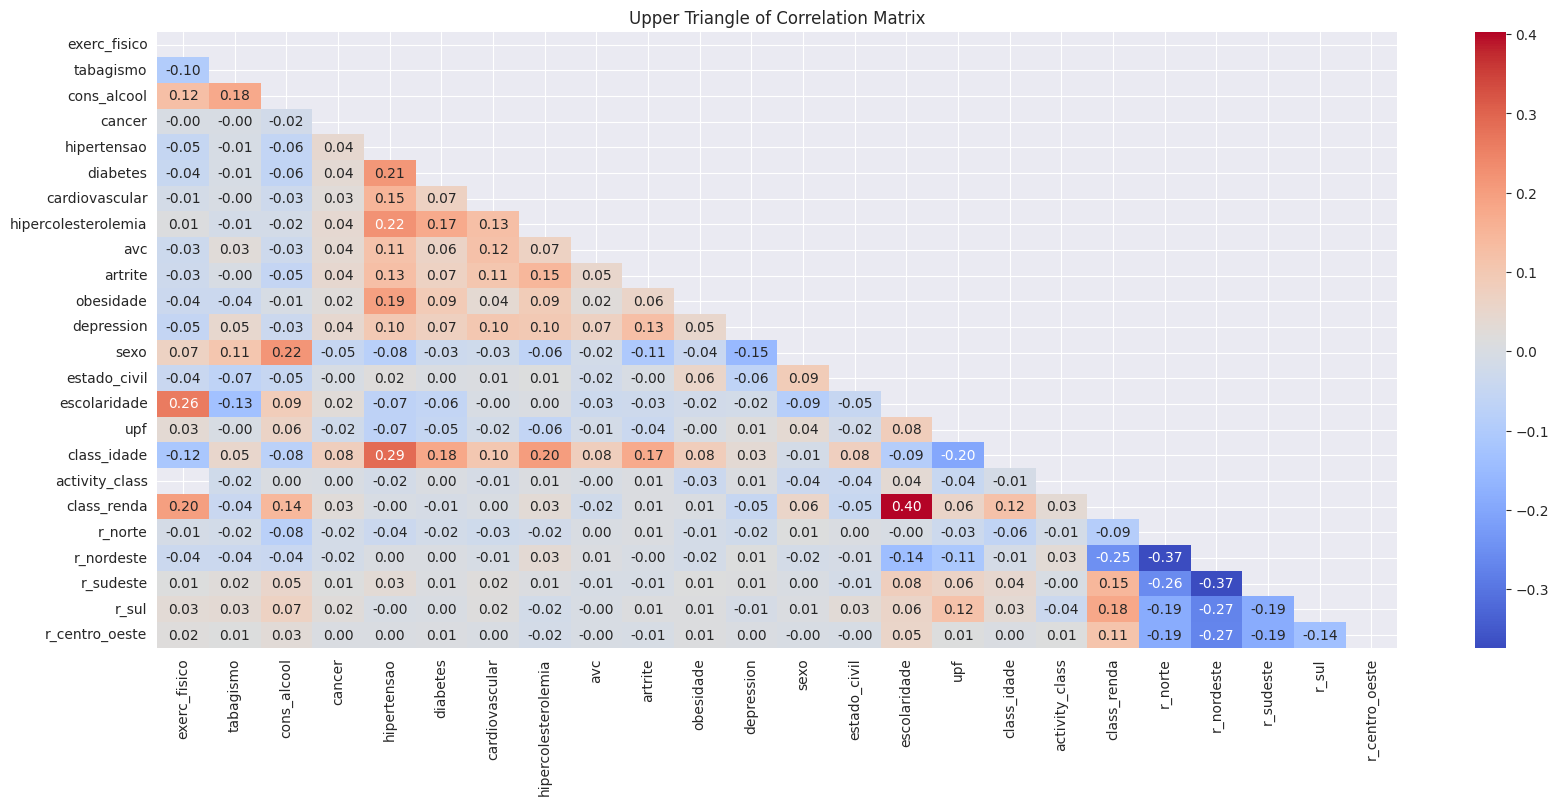

In [13]:
df_total = copy.deepcopy(df_train_total)

corr_matrix = df_total.corr()
correlations = corr_matrix['depression'].abs().sort_values(ascending=False)

mask = np.triu(np.ones(corr_matrix.shape)).astype(bool)
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
ax.set_title("Upper Triangle of Correlation Matrix")
plt.show()

In [14]:
correlations.head(30)

depression             1.000000
sexo                   0.154994
artrite                0.126713
cardiovascular         0.103922
hipertensao            0.098518
hipercolesterolemia    0.096918
diabetes               0.074916
avc                    0.070732
estado_civil           0.064880
exerc_fisico           0.054383
obesidade              0.048270
class_renda            0.047127
tabagismo              0.046258
cancer                 0.043952
class_idade            0.034767
cons_alcool            0.034098
r_norte                0.022605
escolaridade           0.017964
upf                    0.014566
r_nordeste             0.013764
r_sudeste              0.008874
r_sul                  0.007267
activity_class         0.005565
r_centro_oeste         0.004122
Name: depression, dtype: float64

#### Exluindo todos dados nulos

In [15]:
df_total = copy.deepcopy(df_train_total)
df_total = df_total.dropna()

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_dropna')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_dropna')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
0,0.652171,0.649985,0.009858,0.155313,0.1526,0.007957,0.657692,0.646154,0.031056,0.251286,0.246874,0.012512


,value
name,
intercept,0.608503
exerc_fisico,0.008187
tabagismo,0.713458
cons_alcool,-0.022522
cancer,0.692326
hipertensao,0.335504
diabetes,0.508858
cardiovascular,0.631118
hipercolesterolemia,0.441685


#### Usando a média

In [16]:
df_total = copy.deepcopy(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('reg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.named_steps['reg'].coef_[0],  model.named_steps['reg'].intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_meanimp')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_meanimp')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
0,0.653367,0.653522,0.006532,0.184574,0.183702,0.003999,0.658244,0.652863,0.020154,0.288306,0.286699,0.006318


,value
name,
intercept,0.225585
exerc_fisico,-0.217154
tabagismo,0.545113
cons_alcool,-0.005211
cancer,0.526984
hipertensao,0.347865
diabetes,0.462975
cardiovascular,0.885151
hipercolesterolemia,0.452034


### Testando SMOTE

In [17]:

# o SMOTE é uma possibilidade para podermos realizar data augmentation dos dados de pessoas consideradas depressivas
# O desbalanceio das classes é ENORME (~59k não depressivos e 7k depressivos)
# Ele olha a classe com menos quantidade de amostras e gera uma nova distribuição de acordo com as semelhanças entre vizinhos

df_total = copy.deepcopy(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('smt', SMOTE(sampling_strategy='auto', random_state=42)),
    ('reg', LogisticRegression(max_iter=1000, class_weight=None, random_state=42))
])

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.named_steps['reg'].coef_[0],  model.named_steps['reg'].intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_smote')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_smote')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
0,0.624492,0.622769,0.007019,0.176063,0.175187,0.004129,0.684963,0.683931,0.017588,0.280124,0.278912,0.006374


,value
name,
intercept,0.379357
exerc_fisico,-0.280991
tabagismo,0.429822
cons_alcool,0.000232
cancer,0.254042
hipertensao,0.296909
diabetes,0.287701
cardiovascular,0.748980
hipercolesterolemia,0.379118


### Ajuste Hyper-parametro

In [18]:
df_total = copy.deepcopy(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

param_grid = {
    'imp__strategy': ['mean', 'median'],
    'reg__C': [0.1, 1.0, 10.0],
    'reg__solver': ['liblinear', 'saga'],
    'reg__max_iter': [100, 500, 1000]
}


model = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('reg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)
model_log = grid_search.best_estimator_
print("Best params: ")
print(grid_search.best_params_)

model_log, df_metrics = run_model_dep_classification(model_log, X, y)
df_importances = create_df_importances(X.columns, model_log.named_steps['reg'].coef_[0],  model_log.named_steps['reg'].intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_best_grid')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_best_grid')

/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_mode

Best params: 
{'imp__strategy': 'median', 'reg__C': 10.0, 'reg__max_iter': 100, 'reg__solver': 'liblinear'}


exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
0,0.654273,0.654185,0.006889,0.184905,0.184179,0.004114,0.657622,0.653691,0.019685,0.288649,0.287359,0.006376


,value
name,
intercept,0.241891
exerc_fisico,-0.212691
tabagismo,0.550825
cons_alcool,-0.004162
cancer,0.526167
hipertensao,0.355810
diabetes,0.478234
cardiovascular,0.880643
hipercolesterolemia,0.471457


### Variação fatores ao longo do curso da vida e de variaveis sociodemográficas

In [19]:
df_total = copy.deepcopy(df_train_total)

tests = {
    'log_class_renda_baixa': df_total[df_total['class_renda'] == 0.0].drop('class_renda', axis=1),
    'log_class_renda_alta': df_total[df_total['class_renda'] == 1.0].drop('class_renda', axis=1),

    'log_class_sexo_mulher': df_total[df_total['sexo'] == 0].drop('sexo', axis=1),
    'log_class_sexo_homem': df_total[df_total['sexo'] == 1].drop('sexo', axis=1),

    'log_class_idade_less40': df_total[df_total['class_idade'] <= 2].drop('class_idade', axis=1),
    'log_class_idade_more40': df_total[df_total['class_idade'] > 2].drop('class_idade', axis=1),

    'log_class_idade1': df_total[df_total['class_idade'] == 1].drop('class_idade', axis=1),
    'log_class_idade2': df_total[df_total['class_idade'] == 2].drop('class_idade', axis=1),
    'log_class_idade3': df_total[df_total['class_idade'] == 3].drop('class_idade', axis=1),
    'log_class_idade4': df_total[df_total['class_idade'] == 4].drop('class_idade', axis=1),

    'log_class_r_norte': df_total[df_total['r_norte'] == 1].drop(['r_norte', 'r_nordeste', 'r_sudeste', 'r_sul', 'r_centro_oeste'], axis=1),
    'log_class_r_nordeste': df_total[df_total['r_nordeste'] == 1].drop(['r_norte', 'r_nordeste', 'r_sudeste', 'r_sul', 'r_centro_oeste'], axis=1),
    'log_class_r_sudeste': df_total[df_total['r_sudeste'] == 1].drop(['r_norte', 'r_nordeste', 'r_sudeste', 'r_sul', 'r_centro_oeste'], axis=1),
    'log_class_r_sul': df_total[df_total['r_sul'] == 1].drop(['r_norte', 'r_nordeste', 'r_sudeste', 'r_sul', 'r_centro_oeste'], axis=1),
    'log_class_r_centro_oeste': df_total[df_total['r_centro_oeste'] == 1].drop(['r_norte', 'r_nordeste', 'r_sudeste', 'r_sul', 'r_centro_oeste'], axis=1),

}
for key, df_selected in tests.items():
    X = df_selected.drop('depression', axis=1)
    y = df_selected['depression']

    model = Pipeline([
        ('imp', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('reg', LogisticRegression(max_iter=100, class_weight='balanced', solver='liblinear', C=10, random_state=42))
    ])

    model, df_metrics = run_model_dep_classification(model, X, y)
    df_importances = create_df_importances(X.columns, model.named_steps['reg'].coef_[0],  model.named_steps['reg'].intercept_[0])

    df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, key)
    df_importances_all = append_df_importances(df_importances_all, df_importances, key)

    print("{}: {}, f1: {}".format(key, len(df_selected)/ len(df_total), df_metrics['test_f1'][0]))


log_class_renda_baixa: 0.578760162601626, f1: 0.31224862278772275
log_class_renda_alta: 0.4209968186638388, f1: 0.2377110241352703
log_class_sexo_mulher: 0.5165252739483916, f1: 0.32364918626052475
log_class_sexo_homem: 0.48347472605160835, f1: 0.16676438596187534
log_class_idade_less40: 0.5050813008130082, f1: 0.2480359961338293
log_class_idade_more40: 0.4949186991869919, f1: 0.32145892030741646
log_class_idade1: 0.22947596323789324, f1: 0.24036474663688195
log_class_idade2: 0.2756053375751149, f1: 0.25573702747582255
log_class_idade3: 0.2554789678331566, f1: 0.31008491028258733
log_class_idade4: 0.23943973135383528, f1: 0.34583686050127893
log_class_r_norte: 0.20473223753976671, f1: 0.2659764276315795
log_class_r_nordeste: 0.3503004595263344, f1: 0.29415452572153783
log_class_r_sudeste: 0.2060577942735949, f1: 0.30358654280928304
log_class_r_sul: 0.12055938494167551, f1: 0.2696890746535694
log_class_r_centro_oeste: 0.11835012371862849, f1: 0.28424109268081876


## Arvore de Decisão

In [20]:
df_total = copy.deepcopy(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

param_grid = {
    'class__criterion': ['gini', 'entropy'],
    'class__max_depth': [None, 5, 10],
    'class__min_samples_split': np.arange(0, 0.05, 0.01),
    'class__min_samples_leaf': np.arange(0.01, 0.05, 0.01)
}


model = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('class', DecisionTreeClassifier(class_weight='balanced', random_state=43, min_samples_split=0.05, min_samples_leaf=0.01))
])

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)
model_dt = grid_search.best_estimator_
print("Best params: ")
print(grid_search.best_params_)

model_dt, df_metrics = run_model_dep_classification(model_dt, X, y)
df_importances = create_df_importances(X.columns, model_dt.named_steps['class'].feature_importances_,  None)

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'dt_exp')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'dt_exp')

/home/anderson/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/home/anderson/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/home/anderson/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/home/anderso

Best params: 
{'class__criterion': 'gini', 'class__max_depth': None, 'class__min_samples_leaf': 0.01, 'class__min_samples_split': 0.03}


exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
0,0.608696,0.618063,0.006191,0.171963,0.171839,0.003326,0.699461,0.675641,0.016742,0.276057,0.273975,0.005212


,value
name,
exerc_fisico,0.035153
tabagismo,0.061624
cons_alcool,0.009802
cancer,0.000000
hipertensao,0.105093
diabetes,0.000000
cardiovascular,0.000000
hipercolesterolemia,0.051255
avc,0.000000


In [21]:
dot_data = tree.export_graphviz(model_dt.named_steps['class'], out_file=None,
                                feature_names=X.columns,
                                class_names=['False', 'True'],
                                filled=True)
# Draw graph
graph = pydot.graph_from_dot_data(dot_data)[0]
graph.write_svg(PATH_GEN_DATA/"decistion_tree.svg")

In [22]:

df_total = copy.deepcopy(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

param_grid = {
    'class__criterion': ['gini', 'entropy'],
    'class__max_depth': [None, 5, 10],
    'class__min_samples_split': np.arange(0, 0.05, 0.01),
    'class__min_samples_leaf': np.arange(0.01, 0.05, 0.01)
}


model = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('class', RandomForestClassifier(class_weight='balanced', random_state=43, min_samples_split=0.05, min_samples_leaf=0.01))
])

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)
model_rf = grid_search.best_estimator_
print("Best params: ")
print(grid_search.best_params_)

model_rf, df_metrics = run_model_dep_classification(model_rf, X, y)
df_importances = create_df_importances(X.columns, model_rf.named_steps['class'].feature_importances_,  None)

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'rf_exp')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'rf_exp')

/home/anderson/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/home/anderson/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/home/anderson/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File 

Best params: 
{'class__criterion': 'entropy', 'class__max_depth': 5, 'class__min_samples_leaf': 0.01, 'class__min_samples_split': 0.03}


exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
0,0.63598,0.645834,0.009488,0.179109,0.180158,0.00337,0.673364,0.65327,0.019769,0.282954,0.28238,0.004879


,value
name,
exerc_fisico,0.027906
tabagismo,0.030658
cons_alcool,0.007991
cancer,0.000000
hipertensao,0.119655
diabetes,0.023353
cardiovascular,0.054163
hipercolesterolemia,0.080549
avc,0.000000


### Salvando/exibindo tabelas criadas

In [23]:
df_metrics_all.to_excel(PATH_GEN_DATA / 'metrics.xlsx')
df_metrics_all

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
log_apenas_habitos,0.559495,0.556800,0.004056,0.129505,0.129419,0.004002,0.547017,0.550957,0.017824,0.209429,0.209602,0.006519
log_apenas_dcnt,0.728369,0.718348,0.020054,0.189948,0.186161,0.006638,0.443285,0.453719,0.026840,0.265941,0.263577,0.004461
log_apenas_habitos_dcnt,0.694928,0.697371,0.002406,0.184320,0.185690,0.002114,0.510436,0.509985,0.008765,0.270840,0.272245,0.003326
log_apenas_sociodemo,0.574865,0.571310,0.005016,0.159084,0.158242,0.002000,0.694012,0.696374,0.015193,0.258836,0.257874,0.003470
log_all_dropna,0.652171,0.649985,0.009858,0.155313,0.152600,0.007957,0.657692,0.646154,0.031056,0.251286,0.246874,0.012512
log_all_meanimp,0.653367,0.653522,0.006532,0.184574,0.183702,0.003999,0.658244,0.652863,0.020154,0.288306,0.286699,0.006318
log_all_smote,0.624492,0.622769,0.007019,0.176063,0.175187,0.004129,0.684963,0.683931,0.017588,0.280124,0.278912,0.006374
log_best_grid,0.654273,0.654185,0.006889,0.184905,0.184179,0.004114,0.657622,0.653691,0.019685,0.288649,0.287359,0.006376
log_class_renda_baixa,0.652403,0.651411,0.008008,0.204307,0.204109,0.005588,0.662821,0.664423,0.021987,0.312340,0.312249,0.008331
log_class_renda_alta,0.648037,0.647303,0.004554,0.149685,0.147417,0.003627,0.625293,0.613577,0.017577,0.241547,0.237711,0.005888


In [24]:
df_importances_all.to_excel(PATH_GEN_DATA / 'importances.xlsx')
df_importances_all

,log_apenas_habitos,log_apenas_dcnt,log_apenas_habitos_dcnt,log_apenas_sociodemo,log_all_dropna,log_all_meanimp,log_all_smote,log_best_grid,log_class_renda_baixa,log_class_renda_alta,...,log_class_idade2,log_class_idade3,log_class_idade4,log_class_r_norte,log_class_r_nordeste,log_class_r_sudeste,log_class_r_sul,log_class_r_centro_oeste,dt_exp,rf_exp
name,,,,,,,,,,,,,,,,,,,,,
intercept,0.088410,-0.359667,-0.375233,0.427091,0.608503,0.225585,0.379357,0.241891,0.013216,0.408539,...,0.121238,0.197612,0.034473,0.001448,0.308855,0.257830,0.376818,0.830488,NaN,NaN
upf,0.032934,NaN,0.050807,NaN,0.057416,0.058984,0.056578,0.058686,0.053251,0.060752,...,0.067681,0.063658,0.021394,0.088225,0.071569,0.024563,0.062212,0.027930,0.029774,0.006591
exerc_fisico,-0.311056,NaN,-0.268638,NaN,0.008187,-0.217154,-0.280991,-0.212691,-0.143653,-0.308393,...,-0.154655,-0.237238,-0.502369,-0.078057,-0.188528,-0.228098,-0.313365,-0.374788,0.035153,0.027906
tabagismo,0.426645,NaN,0.496894,NaN,0.713458,0.545113,0.429822,0.550825,0.543030,0.568442,...,0.695589,0.395994,0.526877,0.444617,0.516459,0.552490,0.602866,0.728038,0.061624,0.030658
cons_alcool,-0.257500,NaN,-0.168735,NaN,-0.022522,-0.005211,0.000232,-0.004162,-0.040139,0.056121,...,0.093997,-0.046723,-0.262910,0.158943,-0.105818,0.026495,-0.087767,0.073706,0.009802,0.007991
cancer,NaN,0.598822,0.610721,NaN,0.692326,0.526984,0.254042,0.526167,0.581304,0.478124,...,0.367104,0.571829,0.576877,0.634734,0.459694,0.513947,0.758670,0.158946,0.000000,0.000000
hipertensao,NaN,0.332995,0.320104,NaN,0.335504,0.347865,0.296909,0.355810,0.345735,0.365099,...,0.528891,0.336586,0.225295,0.424586,0.411098,0.196823,0.426141,0.312857,0.105093,0.119655
diabetes,NaN,0.442612,0.427649,NaN,0.508858,0.462975,0.287701,0.478234,0.473040,0.480992,...,0.243517,0.666560,0.441631,0.634014,0.423735,0.435860,0.466209,0.443086,0.000000,0.023353
cardiovascular,NaN,0.817326,0.793583,NaN,0.631118,0.885151,0.748980,0.880643,0.959138,0.756567,...,1.074171,0.692436,0.821054,0.950788,0.896213,1.110201,0.467659,0.703731,0.000000,0.054163


# Comparando modelos

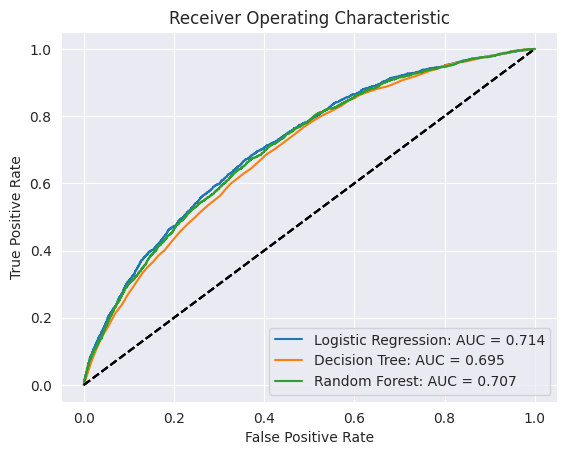

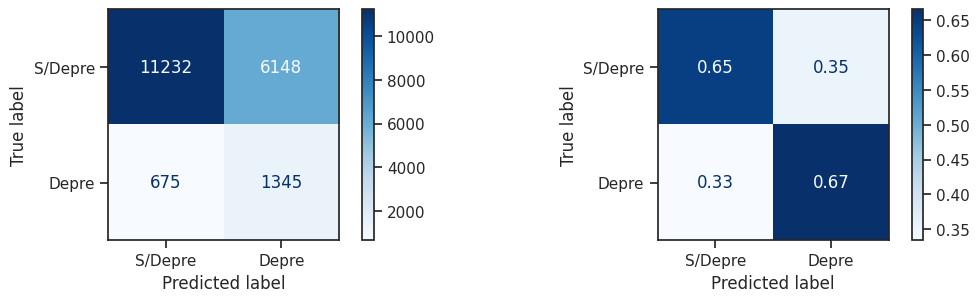

,exp,accuracy_train,precision_train,recall_train,f1_train,accuracy_test,f1_test,precision_test,recall_test
0,Logistic Regression,0.654273,0.184905,0.657622,0.288649,0.648299,0.282771,0.179501,0.665842
1,Decision Tree,0.608696,0.171963,0.699461,0.276057,0.603660,0.265265,0.164358,0.687129
2,Random Forest,0.635980,0.179109,0.673364,0.282954,0.629330,0.275174,0.172763,0.675743


In [25]:
df_total = copy.deepcopy(df_train_total)
X = df_total.drop('depression', axis=1)
y = df_total['depression']

df_test = copy.deepcopy(df_test_total)
X_test = df_test.drop('depression', axis=1)
y_test = df_test['depression']

modeldict = {'Logistic Regression': model_log, 'Decision Tree': model_dt, 'Random Forest': model_rf}

plot_roc_curve(modeldict, X_test, y_test)
plot_cm(model_log, X_test, y_test)

metrics_test = classification_metrics(modeldict, X, y, X_test, y_test)
metrics_test